In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import os
import warnings
warnings.filterwarnings('ignore')

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
path = '/content/drive/MyDrive/Colab Notebooks/data'

## Data Loading and Initial Exploration

In [5]:
# Load the data
df = pd.read_csv(os.path.join(path, 'croprecommend.csv'))

In [6]:
# Display the first few rows
print(df.head())

    N   P   K  temperature   humidity        ph    rainfall label
0  90  42  43    20.879744  82.002744  6.502985  202.935536  rice
1  85  58  41    21.770462  80.319644  7.038096  226.655537  rice
2  60  55  44    23.004459  82.320763  7.840207  263.964248  rice
3  74  35  40    26.491096  80.158363  6.980401  242.864034  rice
4  78  42  42    20.130175  81.604873  7.628473  262.717340  rice


In [7]:
# Display basic information about the dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB
None


In [8]:
# Check for missing values
print(df.isnull().sum())

N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64


In [9]:
# Display summary statistics
print(df.describe())

                 N            P            K  temperature     humidity  \
count  2200.000000  2200.000000  2200.000000  2200.000000  2200.000000   
mean     50.551818    53.362727    48.149091    25.616244    71.481779   
std      36.917334    32.985883    50.647931     5.063749    22.263812   
min       0.000000     5.000000     5.000000     8.825675    14.258040   
25%      21.000000    28.000000    20.000000    22.769375    60.261953   
50%      37.000000    51.000000    32.000000    25.598693    80.473146   
75%      84.250000    68.000000    49.000000    28.561654    89.948771   
max     140.000000   145.000000   205.000000    43.675493    99.981876   

                ph     rainfall  
count  2200.000000  2200.000000  
mean      6.469480   103.463655  
std       0.773938    54.958389  
min       3.504752    20.211267  
25%       5.971693    64.551686  
50%       6.425045    94.867624  
75%       6.923643   124.267508  
max       9.935091   298.560117  


In [10]:
# Check unique values in the 'label' column
print(df['label'].unique())

['rice' 'maize' 'chickpea' 'kidneybeans' 'pigeonpeas' 'mothbeans'
 'mungbean' 'blackgram' 'lentil' 'pomegranate' 'banana' 'mango' 'grapes'
 'watermelon' 'muskmelon' 'apple' 'orange' 'papaya' 'coconut' 'cotton'
 'jute' 'coffee']


## Correlation Analysis

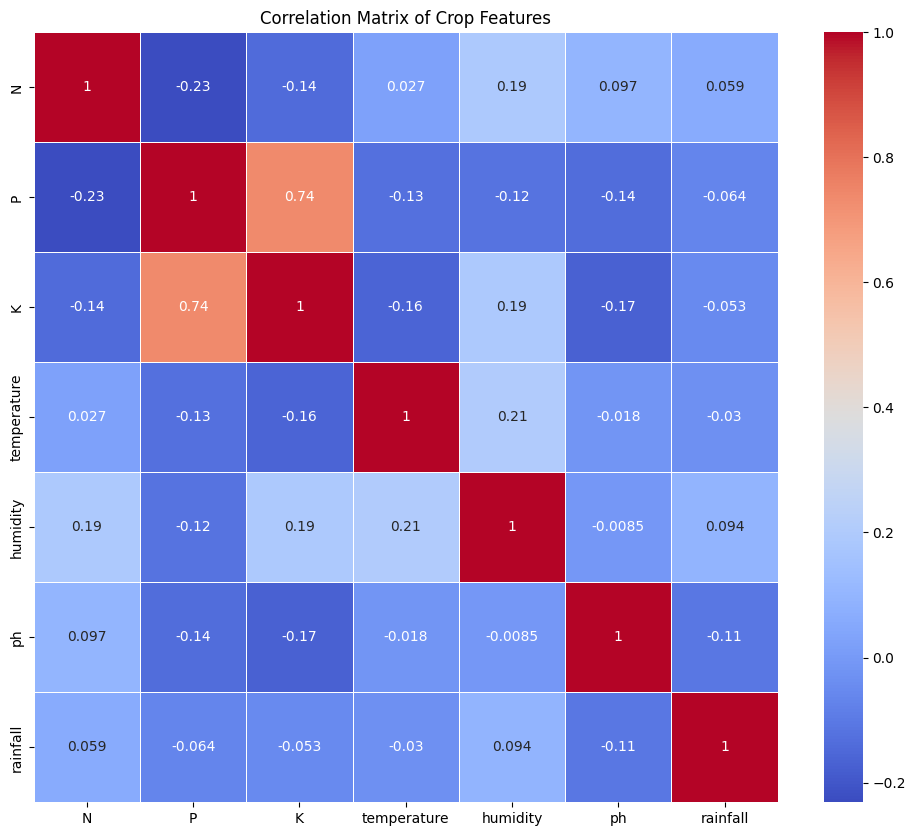

In [11]:
# Correlation Analysis
features = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
correlation_matrix = df[features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Crop Features')
plt.show()

Key Observations:



* The strongest correlation is between P (Phosphorus) and K (Potassium) with a value of 0.74, indicating a strong positive relationship.
* Most of the other correlations are weak (closer to 0), suggesting that these features are relatively independent of each other.
* There are no strong negative correlations present in this matrix.



## Boxplots for Feature Distribution by Crop Type

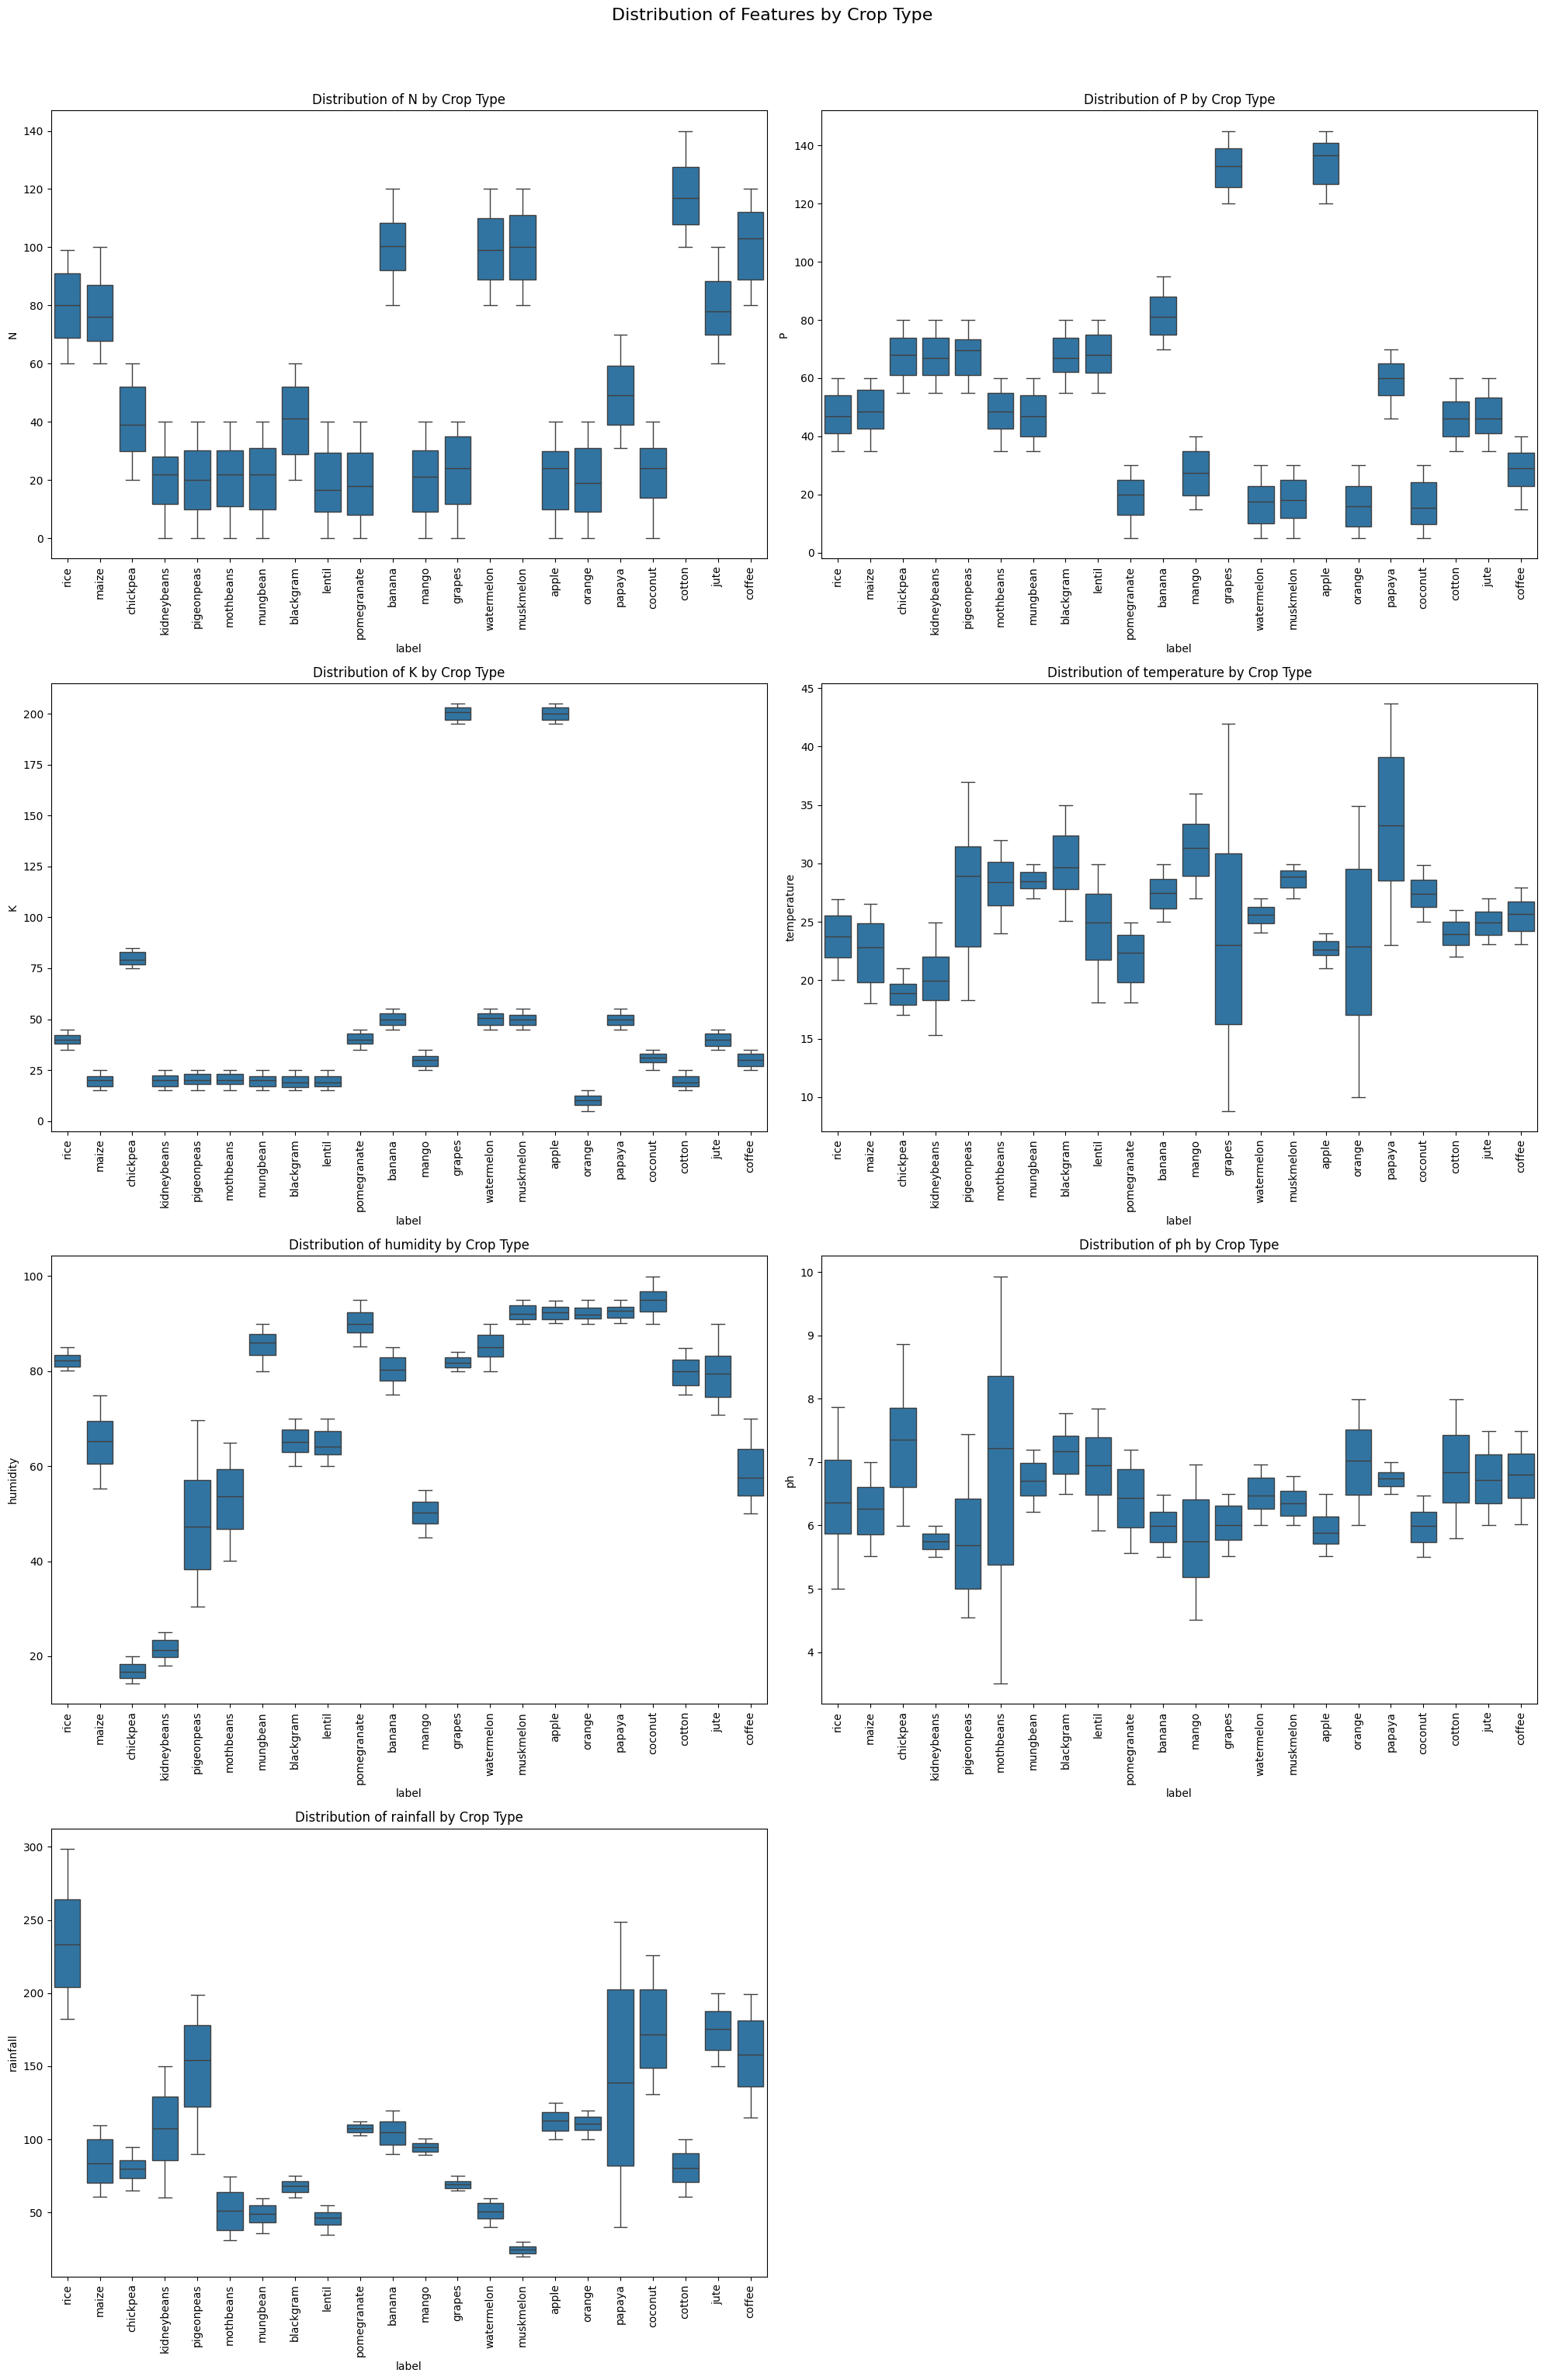

In [12]:
# Create boxplots for each feature by crop type
fig, axes = plt.subplots(4, 2, figsize=(20, 30))
fig.suptitle('Distribution of Features by Crop Type', fontsize=16, y=1.02)

for i, feature in enumerate(features):
    row = i // 2
    col = i % 2
    sns.boxplot(x='label', y=feature, data=df, ax=axes[row, col])
    axes[row, col].set_xticklabels(axes[row, col].get_xticklabels(), rotation=90)
    axes[row, col].set_title(f'Distribution of {feature} by Crop Type')

# Remove the empty subplot
axes[3, 1].remove()

plt.tight_layout()
plt.show()

Key Observations

* N (nitrogen) levels vary between crops, with cotton showing higher requirements.
* P (phosphorus) and K (potassium) is exceptionally high for apple and grapes compared to other crops.
* Temperature ranges are relatively consistent across crops, mostly between 20-30°C.
* Humidity requirements differ significantly, with coconut needing high humidity and chickpea preferring lower levels.
* pH preferences vary, but most crops favor slightly acidic to neutral soils (pH 6-7).
* Rainfall needs differ dramatically, with rice requiring the most water and muskmelon the least.

## Histograms for Feature Distributions

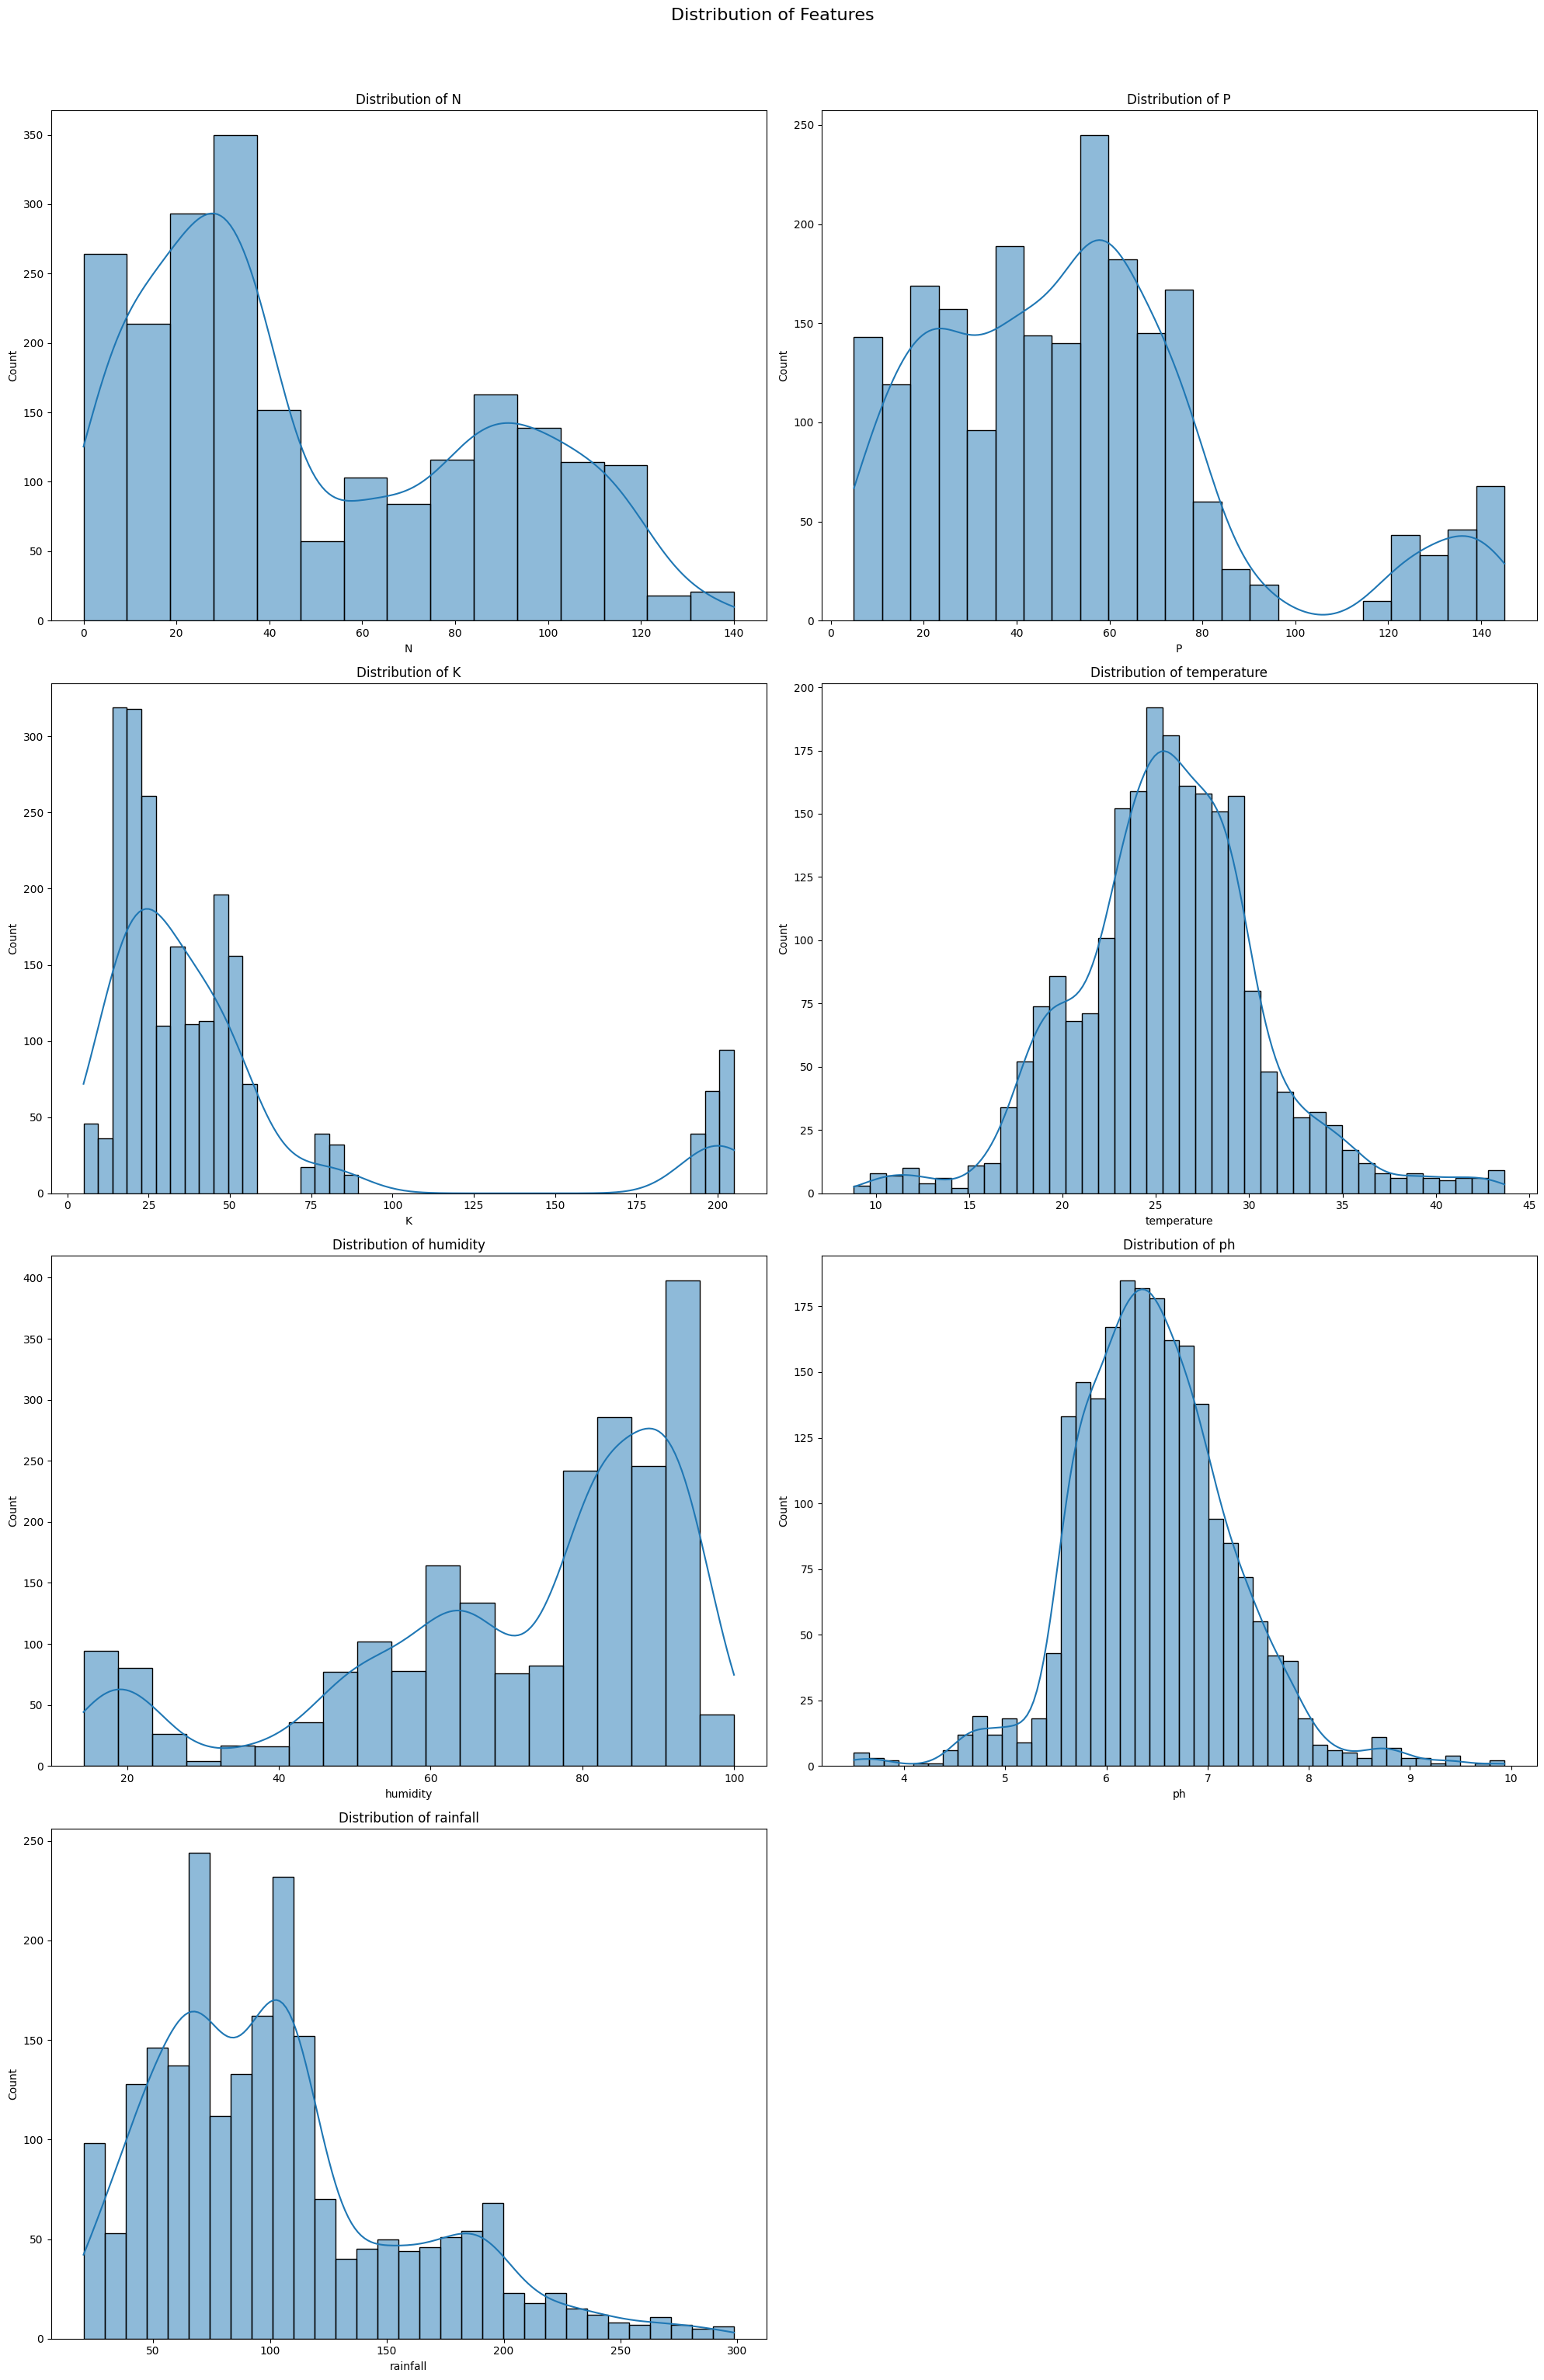

In [13]:
# Create a histogram for each numerical feature
fig, axes = plt.subplots(4, 2, figsize=(20, 30))
fig.suptitle('Distribution of Features', fontsize=16, y=1.02)

for i, feature in enumerate(features):
    row = i // 2
    col = i % 2
    sns.histplot(df[feature], kde=True, ax=axes[row, col])
    axes[row, col].set_title(f'Distribution of {feature}')

# Remove the empty subplot
axes[3, 1].remove()

plt.tight_layout()
plt.show()

Key Observations

* Temperature follows a normal distribution, centering around 25-30°C.
* Humidity has a bimodal distribution, with peaks at low (20-30%) and high (80-90%) levels.
* pH is normally distributed, centered around 6.5-7.
* Rainfall is right-skewed, with most values below 150mm, but some extreme values reaching 300mm.

## Crop Count Visualization

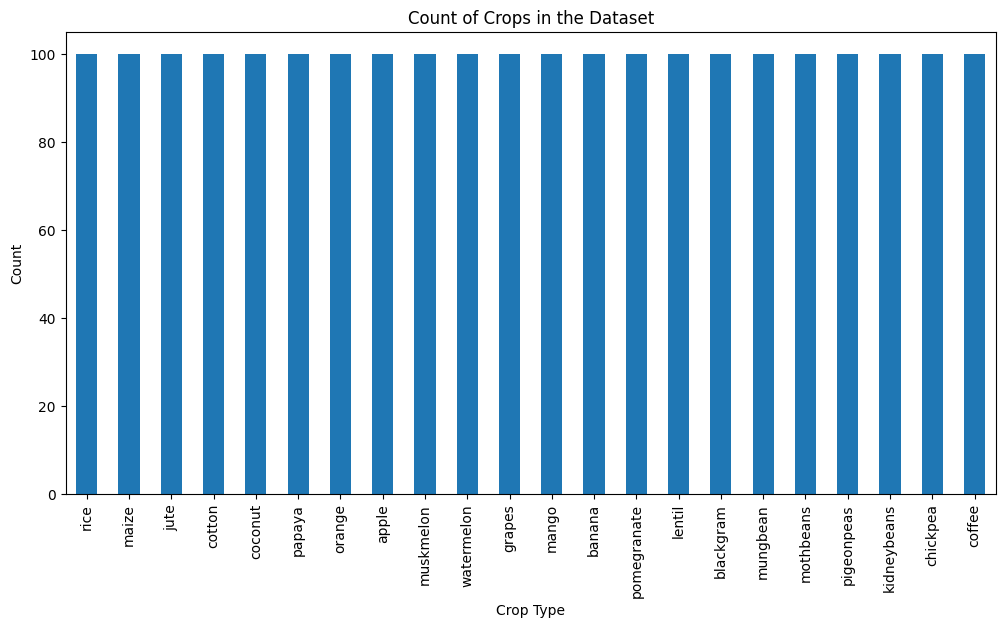

In [14]:
# Create a bar plot of crop counts
plt.figure(figsize=(12, 6))
df['label'].value_counts().plot(kind='bar')
plt.title('Count of Crops in the Dataset')
plt.xlabel('Crop Type')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

## Data Splitting

In [15]:
# Separate features and target
X = df.drop('label', axis=1)
y = df['label']

In [16]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


print("Shape of training set:", X_train.shape)
print("Shape of testing set:", X_test.shape)

Shape of training set: (1760, 7)
Shape of testing set: (440, 7)


## Model Training and Evaluation

In [19]:
# Define the function to train and evaluate models
def train_and_evaluate_model(model, model_name, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\n{model_name} Results:")
    print(classification_report(y_test, y_pred))
    return accuracy

### SVM Model Training and Evaluation


SVM with {'kernel': 'rbf', 'C': 1} Results:
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        23
      banana       1.00      1.00      1.00        21
   blackgram       0.91      1.00      0.95        20
    chickpea       1.00      1.00      1.00        26
     coconut       1.00      1.00      1.00        27
      coffee       1.00      0.94      0.97        17
      cotton       0.85      1.00      0.92        17
      grapes       1.00      1.00      1.00        14
        jute       0.77      1.00      0.87        23
 kidneybeans       0.95      1.00      0.98        20
      lentil       0.79      1.00      0.88        11
       maize       1.00      0.86      0.92        21
       mango       1.00      1.00      1.00        19
   mothbeans       1.00      0.88      0.93        24
    mungbean       1.00      1.00      1.00        19
   muskmelon       1.00      1.00      1.00        17
      orange       1.00      1.00   

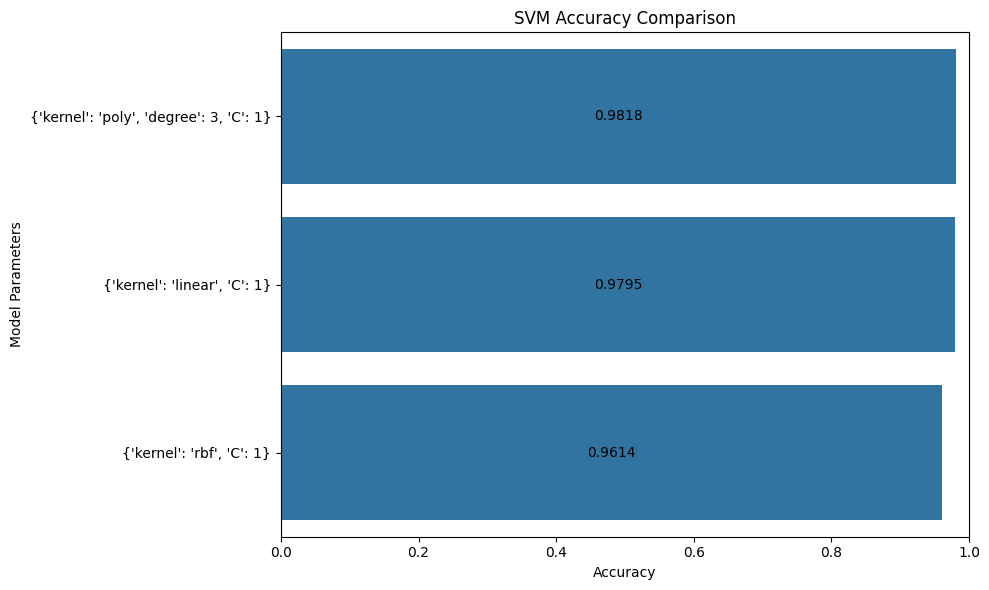


SVM Accuracy Ranking:
1. {'kernel': 'poly', 'degree': 3, 'C': 1}: 0.9818
2. {'kernel': 'linear', 'C': 1}: 0.9795
3. {'kernel': 'rbf', 'C': 1}: 0.9614


In [20]:
# Function to train and evaluate SVM model
def train_and_evaluate_svm_model(params, X_train, y_train, X_test, y_test):
    model = SVC(**params, random_state=42)
    return train_and_evaluate_model(model, f"SVM with {params}", X_train, y_train, X_test, y_test)

# Parameter sets for SVM
svm_params = [
    {"kernel": 'rbf', "C": 1},
    {"kernel": 'linear', "C": 1},
    {"kernel": 'poly', "degree": 3, "C": 1},
]

# Train and evaluate SVM models
svm_accuracies = []
for params in svm_params:
    accuracy = train_and_evaluate_svm_model(params, X_train, y_train, X_test, y_test)
    svm_accuracies.append((params, accuracy))

# Sort accuracies
svm_accuracies.sort(key=lambda x: x[1], reverse=True)

# Plot SVM model accuracies
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x=[acc for _, acc in svm_accuracies], y=[str(params) for params, acc in svm_accuracies])
plt.title('SVM Accuracy Comparison')
plt.xlabel('Accuracy')
plt.ylabel('Model Parameters')
plt.xlim(0, 1)

# Annotate bars with accuracy values
for i, (params, acc) in enumerate(svm_accuracies):
    plt.text(acc / 2, i, f'{acc:.4f}', va='center', ha='center')

plt.tight_layout()
plt.show()

# Print SVM accuracy ranking
print("\nSVM Accuracy Ranking:")
for i, (params, acc) in enumerate(svm_accuracies, 1):
    print(f"{i}. {params}: {acc:.4f}")

### Logistic Regression Model Training and Evaluation


Logistic Regression with {'multi_class': 'ovr', 'max_iter': 1000} Results:
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        23
      banana       1.00      1.00      1.00        21
   blackgram       0.90      0.95      0.93        20
    chickpea       1.00      1.00      1.00        26
     coconut       1.00      0.96      0.98        27
      coffee       0.94      1.00      0.97        17
      cotton       1.00      1.00      1.00        17
      grapes       1.00      1.00      1.00        14
        jute       0.83      0.83      0.83        23
 kidneybeans       1.00      1.00      1.00        20
      lentil       0.92      1.00      0.96        11
       maize       0.91      1.00      0.95        21
       mango       1.00      1.00      1.00        19
   mothbeans       0.96      0.96      0.96        24
    mungbean       1.00      0.95      0.97        19
   muskmelon       1.00      1.00      1.00        17
     

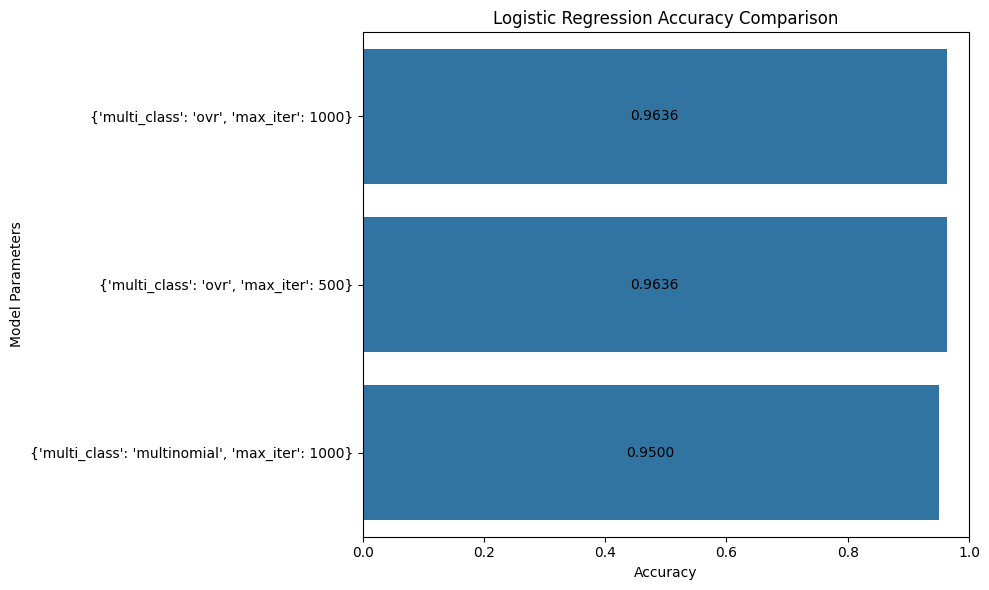


Logistic Regression Accuracy Ranking:
1. {'multi_class': 'ovr', 'max_iter': 1000}: 0.9636
2. {'multi_class': 'ovr', 'max_iter': 500}: 0.9636
3. {'multi_class': 'multinomial', 'max_iter': 1000}: 0.9500


In [21]:
# Function to train and evaluate Logistic Regression model
def train_and_evaluate_lr_model(params, X_train, y_train, X_test, y_test):
    model = LogisticRegression(**params, random_state=42)
    return train_and_evaluate_model(model, f"Logistic Regression with {params}", X_train, y_train, X_test, y_test)

# Parameter sets for Logistic Regression
lr_params = [
    {"multi_class": 'ovr', "max_iter": 1000},
    {"multi_class": 'multinomial', "max_iter": 1000},
    {"multi_class": 'ovr', "max_iter": 500},
]

# Train and evaluate Logistic Regression models
lr_accuracies = []
for params in lr_params:
    accuracy = train_and_evaluate_lr_model(params, X_train, y_train, X_test, y_test)
    lr_accuracies.append((params, accuracy))

# Sort accuracies
lr_accuracies.sort(key=lambda x: x[1], reverse=True)

# Plot Logistic Regression model accuracies
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x=[acc for _, acc in lr_accuracies], y=[str(params) for params, acc in lr_accuracies])
plt.title('Logistic Regression Accuracy Comparison')
plt.xlabel('Accuracy')
plt.ylabel('Model Parameters')
plt.xlim(0, 1)

# Annotate bars with accuracy values
for i, (params, acc) in enumerate(lr_accuracies):
    plt.text(acc / 2, i, f'{acc:.4f}', va='center', ha='center')

plt.tight_layout()
plt.show()

# Print Logistic Regression accuracy ranking
print("\nLogistic Regression Accuracy Ranking:")
for i, (params, acc) in enumerate(lr_accuracies, 1):
    print(f"{i}. {params}: {acc:.4f}")

### Decision Tree Model Training and Evaluation


Decision Tree with {'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1} Results:
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        23
      banana       1.00      1.00      1.00        21
   blackgram       0.95      1.00      0.98        20
    chickpea       1.00      1.00      1.00        26
     coconut       0.96      1.00      0.98        27
      coffee       1.00      1.00      1.00        17
      cotton       1.00      1.00      1.00        17
      grapes       1.00      1.00      1.00        14
        jute       0.92      0.96      0.94        23
 kidneybeans       1.00      1.00      1.00        20
      lentil       0.92      1.00      0.96        11
       maize       1.00      0.95      0.98        21
       mango       1.00      1.00      1.00        19
   mothbeans       1.00      0.92      0.96        24
    mungbean       1.00      1.00      1.00        19
   muskmelon       1.00      1.00      

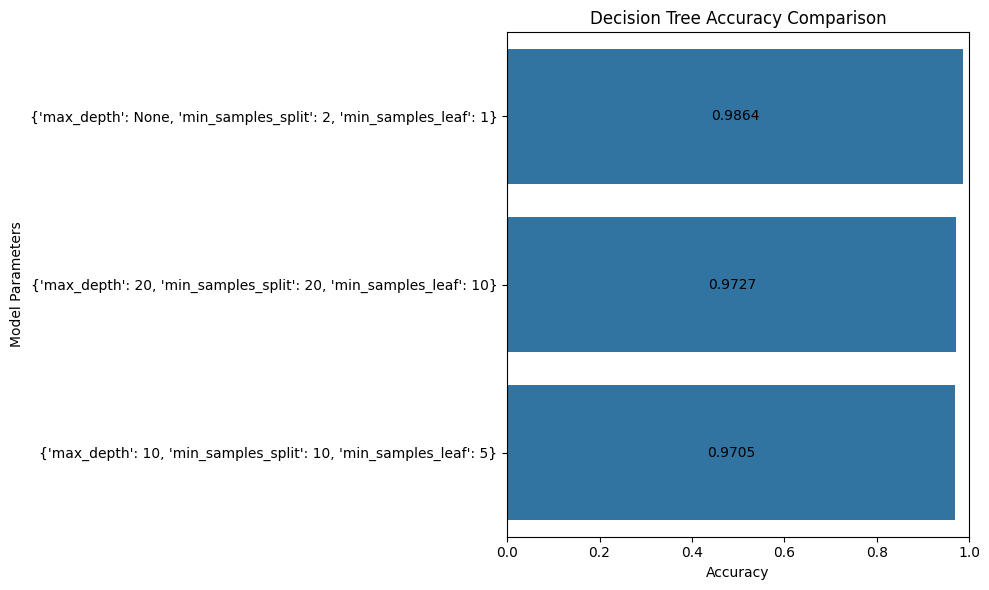


Decision Tree Accuracy Ranking:
1. {'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1}: 0.9864
2. {'max_depth': 20, 'min_samples_split': 20, 'min_samples_leaf': 10}: 0.9727
3. {'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 5}: 0.9705


In [22]:
# Function to train and evaluate Decision Tree model
def train_and_evaluate_dt_model(params, X_train, y_train, X_test, y_test):
    model = DecisionTreeClassifier(**params, random_state=42)
    return train_and_evaluate_model(model, f"Decision Tree with {params}", X_train, y_train, X_test, y_test)

# Parameter sets for Decision Tree
dt_params = [
    {"max_depth": None, "min_samples_split": 2, "min_samples_leaf": 1},
    {"max_depth": 10, "min_samples_split": 10, "min_samples_leaf": 5},
    {"max_depth": 20, "min_samples_split": 20, "min_samples_leaf": 10},
]

# Train and evaluate Decision Tree models
dt_accuracies = []
for params in dt_params:
    accuracy = train_and_evaluate_dt_model(params, X_train, y_train, X_test, y_test)
    dt_accuracies.append((params, accuracy))

# Sort accuracies
dt_accuracies.sort(key=lambda x: x[1], reverse=True)

# Plot Decision Tree model accuracies
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x=[acc for _, acc in dt_accuracies], y=[str(params) for params, acc in dt_accuracies])
plt.title('Decision Tree Accuracy Comparison')
plt.xlabel('Accuracy')
plt.ylabel('Model Parameters')
plt.xlim(0, 1)

# Annotate bars with accuracy values
for i, (params, acc) in enumerate(dt_accuracies):
    plt.text(acc / 2, i, f'{acc:.4f}', va='center', ha='center')

plt.tight_layout()
plt.show()

# Print Decision Tree accuracy ranking
print("\nDecision Tree Accuracy Ranking:")
for i, (params, acc) in enumerate(dt_accuracies, 1):
    print(f"{i}. {params}: {acc:.4f}")

### Random Forest Model Training and Evaluation


Random Forest with {'n_estimators': 100, 'max_depth': None} Results:
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        23
      banana       1.00      1.00      1.00        21
   blackgram       1.00      1.00      1.00        20
    chickpea       1.00      1.00      1.00        26
     coconut       1.00      1.00      1.00        27
      coffee       1.00      1.00      1.00        17
      cotton       1.00      1.00      1.00        17
      grapes       1.00      1.00      1.00        14
        jute       0.92      1.00      0.96        23
 kidneybeans       1.00      1.00      1.00        20
      lentil       0.92      1.00      0.96        11
       maize       1.00      1.00      1.00        21
       mango       1.00      1.00      1.00        19
   mothbeans       1.00      0.96      0.98        24
    mungbean       1.00      1.00      1.00        19
   muskmelon       1.00      1.00      1.00        17
      orang

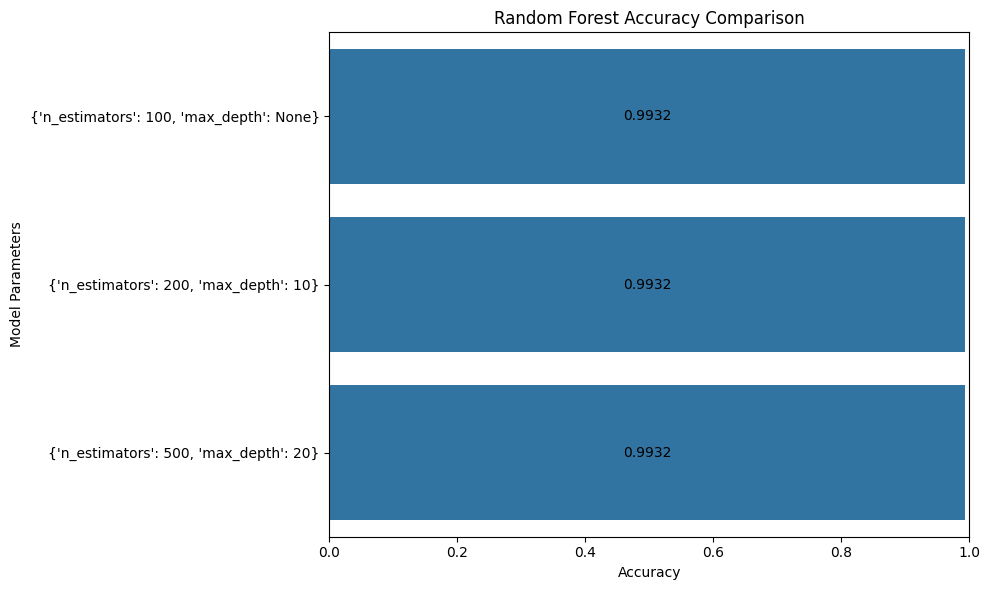


Random Forest Accuracy Ranking:
1. {'n_estimators': 100, 'max_depth': None}: 0.9932
2. {'n_estimators': 200, 'max_depth': 10}: 0.9932
3. {'n_estimators': 500, 'max_depth': 20}: 0.9932


In [23]:
# Function to train and evaluate Random Forest model
def train_and_evaluate_rf_model(params, X_train, y_train, X_test, y_test):
    model = RandomForestClassifier(**params, random_state=42)
    return train_and_evaluate_model(model, f"Random Forest with {params}", X_train, y_train, X_test, y_test)

# Parameter sets for Random Forest
rf_params = [
    {"n_estimators": 100, "max_depth": None},
    {"n_estimators": 200, "max_depth": 10},
    {"n_estimators": 500, "max_depth": 20},
]

# Train and evaluate Random Forest models
rf_accuracies = []
for params in rf_params:
    accuracy = train_and_evaluate_rf_model(params, X_train, y_train, X_test, y_test)
    rf_accuracies.append((params, accuracy))

# Sort accuracies
rf_accuracies.sort(key=lambda x: x[1], reverse=True)

# Plot Random Forest model accuracies
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x=[acc for _, acc in rf_accuracies], y=[str(params) for params, acc in rf_accuracies])
plt.title('Random Forest Accuracy Comparison')
plt.xlabel('Accuracy')
plt.ylabel('Model Parameters')
plt.xlim(0, 1)

# Annotate bars with accuracy values
for i, (params, acc) in enumerate(rf_accuracies):
    plt.text(acc / 2, i, f'{acc:.4f}', va='center', ha='center')

plt.tight_layout()
plt.show()

# Print Random Forest accuracy ranking
print("\nRandom Forest Accuracy Ranking:")
for i, (params, acc) in enumerate(rf_accuracies, 1):
    print(f"{i}. {params}: {acc:.4f}")

## Model Selection

In [ ]:
# Select the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

In [ ]:
# Specify the path to save the model in Google Drive
model_path = '/content/drive/MyDrive/Colab Notebooks/models'

# Create the directory if it doesn't exist
if not os.path.exists(model_path):
    os.makedirs(model_path)

In [ ]:
# Save the trained model to the specified path in Google Drive
with open(os.path.join(model_path, 'crop-sage-model.pkl'), 'wb') as model_file:
    pickle.dump(rf_model, model_file)

In [ ]:
# Load the trained model from the specified path in Google Drive
with open(os.path.join(model_path, 'crop-sage-model.pkl'), 'rb') as model_file:
    loaded_model = pickle.load(model_file)

In [ ]:
print("Loaded model type:", type(loaded_model))
print("Loaded model attributes:", dir(loaded_model))
print("Number of estimators:", loaded_model.n_estimators)

In [ ]:
# User Input for Testing
print("\nEnter the following details to get the crop recommendation:")
N = float(input("Enter the Nitrogen (N) value: "))
P = float(input("Enter the Phosphorus (P) value: "))
K = float(input("Enter the Potassium (K) value: "))
temperature = float(input("Enter the temperature: "))
humidity = float(input("Enter the humidity: "))
ph = float(input("Enter the pH value: "))
rainfall = float(input("Enter the rainfall: "))

In [ ]:
# Create a DataFrame with user input
user_input = pd.DataFrame({
    'N': [N],
    'P': [P],
    'K': [K],
    'temperature': [temperature],
    'humidity': [humidity],
    'ph': [ph],
    'rainfall': [rainfall]
})

In [ ]:
# Load the saved model from the specified path in Google Drive
with open(os.path.join(model_path, 'crop-sage-model.pkl'), 'rb') as model_file:
    loaded_model = pickle.load(model_file)

In [ ]:
# Make prediction using the loaded model
prediction = loaded_model.predict(user_input)

In [ ]:
# Print the crop recommendation
print("\nCrop Recommendation:")
print(prediction[0])